# Preprocessing gene expression data

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  Quick shot at maching learning, to make sure data is ok.

In [25]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

import os

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

## 1.  Loading the data

In this section, we load the gene expression data and metadata.  The sequencing data is stored in a series of quant.sf files, one for each cell.  The metadata is stored in a separate file.  We use the metadata to select single-cells from an experiment.  The first function loads the metadat.

In [132]:
def getmeta(experiment, filename = 'META_DATA_InVitro.csv', report=True):
    df = pd.read_csv(filename, sep=',',
                     index_col=2, header=0, low_memory=False)
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    df = df[ df['Number_Of_Cells'] == 1] # Get rid of bulks.
    if report:
        print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [133]:
meta_df = getmeta('P1902')

361 single cells found in experiment P1902
9 Clones: E4, A7, A8, G6, G8, H2, H9, B4, F3
The first five rows of the dataframe are below


,Project_ID,Donor,Number_Of_Cells,Clone_ID,In_Vivo_Clone_ID
Sample_ID,,,,,
P1902_1289,P1902,YFV2001,1,E4,52.0
P1902_1290,P1902,YFV2001,1,E4,52.0
P1902_1291,P1902,YFV2001,1,E4,52.0
P1902_1292,P1902,YFV2001,1,E4,52.0
P1902_1293,P1902,YFV2001,1,A7,46.0


The sequencing data (in a quant.sf file) contains a separate row for each *isoform* of each gene.  The name of each row contains various information (separated by pipe-characters), from which we extract the gene name.

In [134]:
def get_genename(longname):
    split_name = longname.split('|')
    if len(split_name) >= 5:
        return split_name[5]
    else:
        return 'notagene'

The following function locates a quant.sf file from a cell name.  Once located, the data is loaded into a data frame and output.

In [135]:
def load_cell(sample_id):
    path = sample_id[:5]
    folderlist = os.listdir(path)
    folders = [f for f in folderlist if sample_id in f]
    if len(folders) == 0:
        raise FileNotFoundError('Cell data not found')
        return None
    elif len(folders) > 1:
        print('Multiple files found, and I cannot choose.')
        return None
    else:
        cwd = os.getcwd()
        path_to_cell = os.path.join(path,folders[0],'quant.sf')
        df = pd.read_csv(path_to_cell, sep='\t',
                         index_col=0, header=0, low_memory=False)
        df.index = [get_genename(longname) for longname in df.index]
        df = df.loc[ df.index != 'notagene']
        df.name = sample_id
        return df

The data for each cell is complicated -- more than we need to work with.  We care about the counts for each gene, putting all isoforms together at the moment.  The following function takes a dataframe for a cell, and outputs a series of gene expressions, indexed by genes.  We use the TPM-normalized gene expressions here.  As these are transcripts-per-million, their sum should be somewhat close to 1 million.  Perhaps there is some error from spike-in contributions?

In [136]:
def get_TPM(cell, tolerance = 10000, verbose = False):
    cg = cell.groupby(cell.index)['TPM'].sum()
    cg.name = cell.name
    sum_error = np.abs(cg.sum() - 1000000)
    if verbose:
        print('Gene expression (TPM) found for {} genes.'.format(len(cg)))
        print('{0:2.0%} of expressions are zero.'.format(cg.astype(bool).sum() / len(cg)))
    if sum_error <= tolerance:
        return cg
    else:
        print('Warning:  TPM total should be within {} of 1 million.'.format(tolerance))
        return cg

The next function loads an entire *list* of cells, and places their gene expression data into the rows of a matrix.  The rows are indexed by the cell names, and the columns by genes.  The data is the TPM-normalized gene expression.  This may take a little while, so we give progress updates every 10 cells.

In [137]:
def expression_matrix(cell_list):
    list_of_df = []
    cells_processed = 0
    for cell_name in cell_list:
        cell = load_cell(cell_name)
        list_of_df.append(get_TPM(cell, verbose=False))
        cells_processed += 1
        if cells_processed % 10 == 0:
            cells_remaining = len(cell_list) - cells_processed
            print('{} cells processed and {} cells remaining.'.format(cells_processed, cells_remaining))
    return pd.concat(list_of_df, axis=1).transpose()

In [147]:
EM = expression_matrix(list(meta_df.index))

10 cells processed and 351 cells remaining.
20 cells processed and 341 cells remaining.
30 cells processed and 331 cells remaining.
40 cells processed and 321 cells remaining.
50 cells processed and 311 cells remaining.
60 cells processed and 301 cells remaining.
70 cells processed and 291 cells remaining.
80 cells processed and 281 cells remaining.
90 cells processed and 271 cells remaining.
100 cells processed and 261 cells remaining.
110 cells processed and 251 cells remaining.
120 cells processed and 241 cells remaining.
130 cells processed and 231 cells remaining.
140 cells processed and 221 cells remaining.
150 cells processed and 211 cells remaining.
160 cells processed and 201 cells remaining.
170 cells processed and 191 cells remaining.
180 cells processed and 181 cells remaining.
190 cells processed and 171 cells remaining.
200 cells processed and 161 cells remaining.
210 cells processed and 151 cells remaining.
220 cells processed and 141 cells remaining.
230 cells processed

In [177]:
EM.to_pickle('P1902_EM.pkl') # Save file as a pickle.
meta_df.to_pickle('P1902_meta.pkl') # Pickle the metadata too.

## 2.  Munging data

Now we filter and log-scale the gene expression data, for downstream use.

In [180]:
EM = pd.read_pickle('P1902_EM.pkl') # Load file from the pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from the pickle.

In [181]:
genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

The following loads a list of genes to be excluded from the data for later analysis.  The excluded genes should be given in a csv file with *one* column.  No row labels should be given.  The first row should be a descriptive header, like "Genes to exclude."

In [159]:
exc_filename = 'TRgenes.csv'  # CHANGE this if needed.  I added TRAC and TRDV3 as requested.
exc_df = pd.read_csv(exc_filename, sep=',', header=0)
exclude_genes = exc_df.iloc[:,0].tolist()

In [160]:
'TRAC' in exclude_genes # Just checking.

True

In [161]:
def get_relevant(gf, eg, prevalence=0.05, threshold = 10):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    10 counts or more.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [162]:
genes_relevant = get_relevant(EM, exclude_genes)

In [163]:
print("{} cells are measured, from {} to {}.".format(len(cells), cells[0], cells[-1])) 
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in exclude_genes if gene in genes]
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), genes_relevant[0], genes_relevant[-1]))

361 cells are measured, from P1902_1289 to P1902_1672.
20209 genes are measured, from A1BG to ZZZ3.
194 TCR genes were excluded, from TRGC1 to TRDV3.
7418 genes are considered relevant, from A1BG to ZZZ3.


Now we pull out the gene expression for relevant genes.  Then we cut off all negative gene-expression, and normalize the gene expression on a log-scale.  So a gene-expression value of $x$ will be replaced by $\log(1 + max(x,0))$ (natural logarithm).

In [164]:
EM_log = EM[genes_relevant].copy()  # Make a copy in memory
EM_log.clip_lower(0, inplace = True) # Clip negative counts to zero.
EM_log = EM_log.transform(np.log1p) # Apply log(1+x) transform.

In [165]:
EM_log[:5]

,A1BG,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARSD1,...,ZSCAN26,ZSCAN30,ZSCAN32,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZZ3
P1902_1289,4.513434,0.0,1.353799,0.621340,1.044681,0.041873,0.0,0.07247,0.0,5.8099,...,0.0,1.833140,0.0,0.321989,0.0,0.0,1.996958,0.0,1.005958,0.0
P1902_1290,0.000000,0.0,0.502134,0.000000,0.330652,0.007939,0.0,0.00000,0.0,0.0000,...,0.0,0.000000,0.0,0.040175,0.0,0.0,0.000000,0.0,0.000000,0.0
P1902_1291,0.000000,0.0,1.222735,3.977072,2.701510,1.562646,0.0,0.00000,0.0,0.0000,...,0.0,0.868620,0.0,1.815784,0.0,0.0,0.004547,0.0,2.517730,0.0
P1902_1292,0.000000,0.0,3.129561,0.000000,1.132231,6.661877,0.0,0.00000,0.0,0.0000,...,0.0,4.362951,0.0,3.122234,0.0,0.0,0.000000,0.0,0.000000,0.0
P1902_1293,0.000000,0.0,4.136987,0.000000,3.504265,0.235704,0.0,0.00000,0.0,0.0000,...,0.0,1.987798,0.0,5.844823,0.0,0.0,0.000000,0.0,0.000000,0.0


Now we examine the zeros and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above the cutoff).  The *mean nonzero* is the mean of the (log-normalized) expression of the gene, restricting to the expressions above the cutoff.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.  By default, the cutoff should be given in "absolte" terms, i.e., before log-normalization.  A cutoff of 10 seems reasonable.

In [169]:
def dropmean(df, cutoff, absolute=True):
    behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log(cutoff + 1)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

To choose a reasonable cutoff, one can begin with a cutoff of zero, then increase the cutoff until the graph below loses the blob at the bottom right.  In other words, we should not find a clump of genes with very high nonzero ratio and low mean nonzero value.

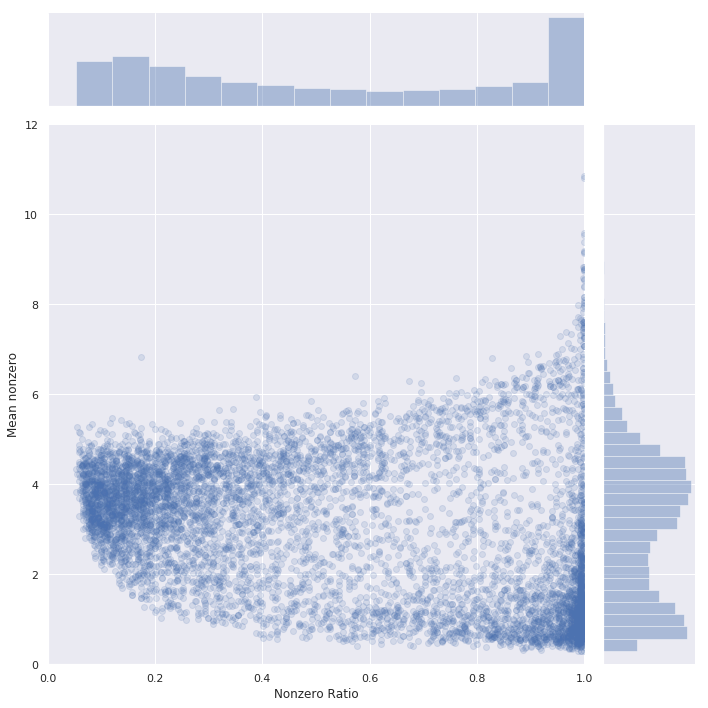

In [174]:
dm_df = dropmean(EM_log, 0) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

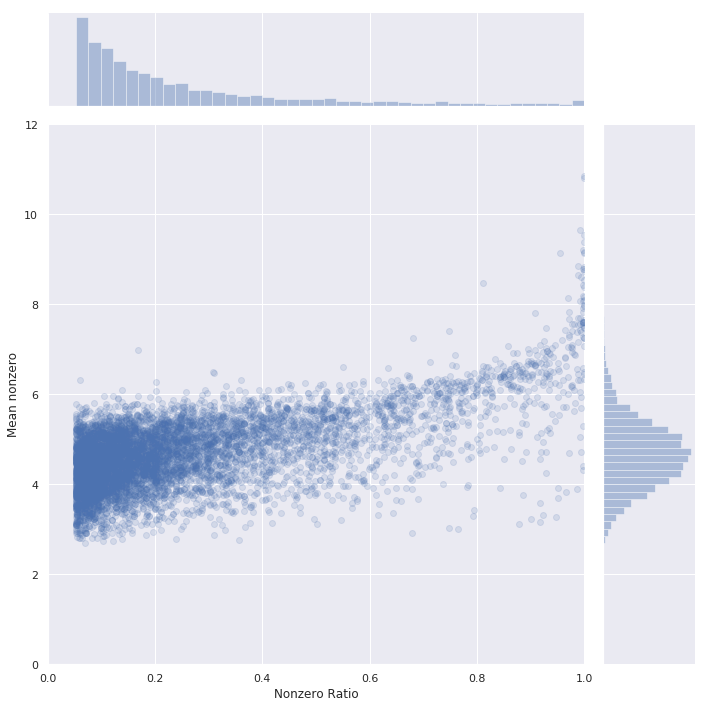

In [175]:
dm_df = dropmean(EM_log, 10) # Now impose a cutoff of 10.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

## 3.  Quick shot at machine learning

In [188]:
# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE


In [189]:
X = EM_log
y = meta_df.Clone_ID

In [190]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

In [191]:
# Expect convergence warnings!  Increase max_iter above if you don't want them.

param_grid = dict(linearsvc__C=[0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                  selectkbest__k = range(50,1051,100),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda/envs/Genomics/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the num

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x1c456a5bf8>)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'linearsvc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'selectkbest__k': range(50, 1051, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [192]:
def CV_map(gs):  # parameter_grid and grid_search.
    means = gs.cv_results_['mean_test_score']
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in gs.cv_results_['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(list(gs.param_grid.keys())[1])
    ax.set_ylabel(list(gs.param_grid.keys())[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

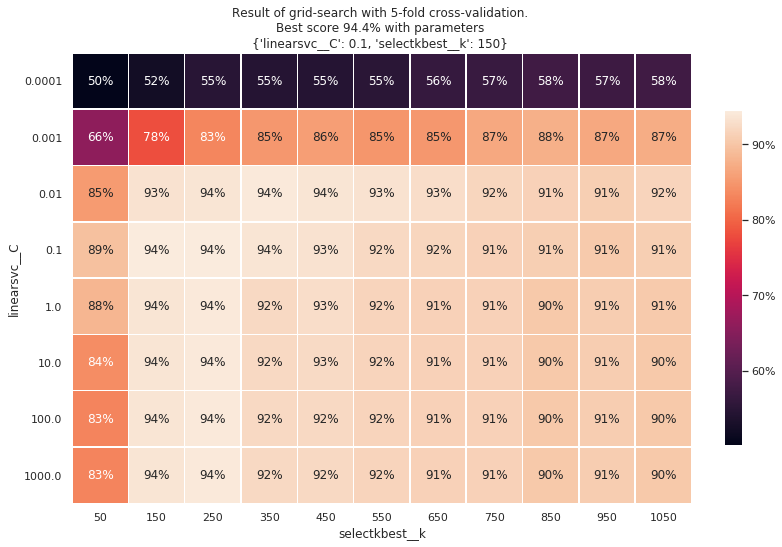

In [193]:
CV_map(grid_search)

In [194]:
def validate_map(predicted, actual):
    correct = 0
    #total = 0 
    classes = sorted(list(set(actual) | set(predicted)) )
    counts = pd.DataFrame(0, index=classes, columns=classes)
    #cpops = pd.DataFrame(0,index=classes, columns=['pop'])
    cpops = actual.value_counts().sort_index()
    for j in range(len(actual)):
        if actual[j] == predicted[j]:
            correct += 1
        #cpops.loc[actual[j],'pop'] += 1
        counts.loc[actual[j], predicted[j]] += 1
        #total += 1
    valid = counts.apply(lambda column : column/cpops) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=counts, square=True, fmt="d", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Class prediction accuracy {:0.3%}.".format(correct/len(actual))) #total))

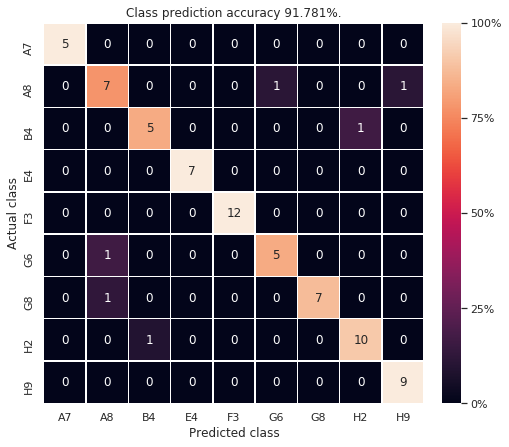

In [195]:
opt_k = grid_search.best_params_['selectkbest__k']
opt_C = grid_search.best_params_['linearsvc__C']

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

SVMpipe.fit(X_train, y_train)
y_pred = SVMpipe.predict(X_test)

validate_map(y_pred,y_test)